
Fold 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.1187152011053902
Epoch 2, Loss: 1.1057921988623483
Epoch 3, Loss: 1.0975849628448486
Epoch 4, Loss: 1.0951481206076485
Epoch 5, Loss: 1.0173438106264387
Epoch 6, Loss: 0.8342861873762948
Epoch 7, Loss: 0.641912409237453

Fold 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.1154931102480208
Epoch 2, Loss: 1.0876025812966483
Epoch 3, Loss: 1.0687394993645805
Epoch 4, Loss: 1.017250997679574
Epoch 5, Loss: 0.8670815910611834
Epoch 6, Loss: 0.6565519571304321
Epoch 7, Loss: 0.5456504949501583


C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Stefa\OneDrive\Dokumente\_Studium\Master\Semester 2\Speech and Language Processing\Git PSTA\SLP\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarnin


Fold 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.1136382137026106
Epoch 2, Loss: 1.074366671698434
Epoch 3, Loss: 1.0330328941345215
Epoch 4, Loss: 0.9420371566499982
Epoch 5, Loss: 0.8659808550562177
Epoch 6, Loss: 0.7687935403415135
Epoch 7, Loss: 0.7039874025753566

Average Classification Report:
Dementia: {'precision': np.float64(0.10833333333333334), 'recall': np.float64(0.12222222222222223), 'f1-score': np.float64(0.11188811188811189), 'support': np.float64(5.333333333333333)}
HC: {'precision': np.float64(0.6494918699186992), 'recall': np.float64(0.6697530864197531), 'f1-score': np.float64(0.6374121420821738), 'support': np.float64(27.333333333333332)}
MCI: {'precision': np.float64(0.4993809058325187), 'recall': np.float64(0.46140350877192987), 'f1-score': np.float64(0.45474654377880186), 'support': np.float64(19.666666666666668)}
accuracy: 0.5348330914368651
macro avg: {'precision': np.float64(0.4190687030281837), 'recall': np.float64(0.4177929391379684), 'f1-score': np.float64(0.4013489325830291), 'support': 

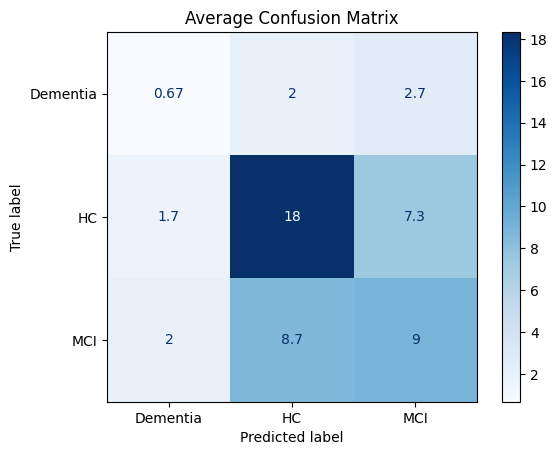

In [2]:
import os
import re
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Custom Dataset
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Helper Functions
def load_data(file_pattern):
    data = []
    record_ids = []
    for root, _, files in os.walk("../process/PROCESS-V1/"):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

def load_labels(label_file):
    df = pd.read_csv(label_file)
    df['label'] = df['Class'].astype('category').cat.codes
    label_map = df.set_index('Record-ID')['label'].to_dict()
    return label_map, dict(enumerate(df['Class'].astype('category').cat.categories))

# Initialize
label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels, class_mapping = load_labels(label_file)
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern)

y = [labels.get(record_id, 0) for record_id in record_ids]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Cross Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
max_len = 512
batch_size = 16
num_epochs = 7

# Collect metrics
all_reports = []
confusion_matrices = []

fold = 1
for train_index, val_index in skf.split(data, y):
    print(f"\nFold {fold}")

    X_train = [data[i] for i in train_index]
    X_val = [data[i] for i in val_index]
    y_train = [y[i] for i in train_index]
    y_val = [y[i] for i in val_index]

    train_dataset = CustomTextDataset(X_train, y_train, tokenizer, max_len)
    val_dataset = CustomTextDataset(X_val, y_val, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights
    class_counts = np.bincount(y_train)
    class_weights = torch.tensor([1.0 / count if count > 0 else 0.0 for count in class_counts], dtype=torch.float).to(device)

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(class_mapping))
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

    model.eval()
    y_pred = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'label'}
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            y_pred.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Compute Metrics for Fold
    report = classification_report(true_labels, y_pred, output_dict=True, target_names=[class_mapping[i] for i in range(len(class_mapping))])
    cm = confusion_matrix(true_labels, y_pred)

    all_reports.append(report)
    confusion_matrices.append(cm)

    fold += 1

# Average Metrics
avg_report = defaultdict(dict)
for key in all_reports[0].keys():
    if isinstance(all_reports[0][key], dict):  # For class-wise metrics
        for metric in all_reports[0][key].keys():
            avg_report[key][metric] = np.mean([report[key][metric] for report in all_reports])
    else:  # For overall metrics like accuracy
        avg_report[key] = np.mean([report[key] for report in all_reports])

print("\nAverage Classification Report:")
for key, value in avg_report.items():
    print(f"{key}: {value}")

# Average Confusion Matrix
avg_cm = np.mean(confusion_matrices, axis=0)
print("\nAverage Confusion Matrix:")
print(avg_cm)

# Plot Average Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=[class_mapping[i] for i in range(len(class_mapping))])
disp.plot(cmap=plt.cm.Blues)
plt.title("Average Confusion Matrix")
plt.show()
